<a href="https://colab.research.google.com/github/kiyong21c/kaggle/blob/main/20220701_Aerial-Cactus-Identification-modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 항공 사진 내 선인장 식별
 - 항공 사진 내 선인장이 있을 확률 예측
 - 문제유형 : 이진분류
 - 평가지표 : ROC AUC(1: 완벽히 예측)
 - 사용모델 : 기본 CNN
 - 훈련/테스트/샘플제출 데이터 이외 이미지 데이터(훈련/테스트)

## 베이스라인 모델
 - 모델링 전략

  > 베이스라인 모델 : 얕은 CNN

   - 신경망 구조 : 합성곱(x2), 풀링, 평탄화, 전결합
   - 옵티마이저 : SGD

  > 성능 개선 : 살짝 깊은 CNN

   - 데이터 증강 : 다양한 변환기 사용
   - 신경망 구조 : 합성곱(x5), 배치 정규화, 풀링, 평탄화, 전결합(x2)
   - 옵티마이저 : Adamax
   - 기타 : 훈련 에폭 수 증가

### 시드값 고정 및 GPU 장비 설정

#### 시드값 고정
 - 다시 실행해도 같은 결과를 얻기 위함
 - 머신러닝의 random_state 파라미터 역할
 - **파이토치로 딥러닝 모델링시 모델 훈련시가 아니라 맨처음에 시드값 고정**

In [71]:
import torch
import random
import numpy as np
import os

# 시드값 고정
## 이 모든 시드값 고정 코드가 반드시 필요한건 아니다(다른 환경에 다양하게 적용되도록 많은 시드 고정)
## 파이토치는 시드값 고정하더라도 해시값들에 의해 결과달라질수 있음
## 시드값 고정시 속도 저하 및 예측 성능 저하될 수 있음(결과를 재현할 필요 있을시에만 시드고정)
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)               # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)            # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)         # 파이토치 난수 생성기 시드 고정(CPU 사용시)
torch.cuda.manual_seed(seed)     # 파이토치 난수 생성기 시드 고정(GPU 사용시)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정(멀티GPU 사용시)
torch.backends.cudnn.deterministic= True    # 확정적 연산 사용
torch.backends.cudnn.benchmark= False       # 벤치마크 기능 해제
torch.backends.cudnn.enabled= False         # cudnn 사용 해제

#### GPU 장비 설정
 - 정형 데이터(csv파일 등)를 다루는 머신러닝 경진대회
 - 비정형 데이터(이미지, 음성, 텍스트)를 다루는 딥러닝 경진대회
  
  > 비정형 데이터 : 연산량이 많다 → GPU 사용(수만개의 단순연산을 병렬로 처리)

In [72]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


장비 설정 코드는 아래와 같이 한줄로도 표현 가능
```
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
```



 - CUDA : 엔비디아 개발한 병렬처리 플랫폼

In [73]:
device

device(type='cpu')

 - 아무 설정 하지 않으면 **CPU**
 - 런타임 유형 GPU변경시 **cuda**

 - device 변수에 CUDA가 할당됨
 - 여기에 모델과 데이터를 추후 할당 예정

### 데이터 준비
 - 훈련/검증 데이터 분리
 - 데이터셋 클래스 정의(변환기)

  > 변환기가 원본 데이터를 다양한 형태로 변환

  > 모델 훈련에 필요한 데이터를 미니배치 단위로 공급
 - 데이터셋 생성
 - 데이터 로더 생성

 - Tip : 폴더 삭제 방법
```
import shutil
shutil.rmtree('/content/drive/MyDrive/Colab Notebooks/kaggle/input/Aerial-Cactus-Identification/test', ignore_errors=True)
shutil.rmtree('/content/drive/MyDrive/Colab Notebooks/kaggle/input/Aerial-Cactus-Identification/train', ignore_errors=True)
```



In [74]:
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/Aerial-Cactus-Identification/'

labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [75]:
from zipfile import ZipFile

# 훈련 이미지 데이터 압축 풀기
with ZipFile(data_path + 'train.zip') as zipper:
    zipper.extractall() # zip파일이 있던 경로가 아닌 'content/train'에 압축이 해제됨

# 테스트 이미지 데이터 압축 풀기
with ZipFile(data_path + 'test.zip') as zipper:
    zipper.extractall() # zip파일이 있던 경로가 아닌 'content/test'에 압축이 해제됨

#### 훈련 데이터, 검증 데이터 분리
 - 현재의 labels에는 train.csv가 담겨있음
 - 이 데이터를 훈련/검증 데이터로 나눔

In [76]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(labels,     # data, target 두가지를 전달하여 X_train, X_valid, y_train, y_valid 나눌수도 있음
                                test_size=0.1,
                                stratify=labels['has_cactus'], # 타깃값의 열이름 전달해서 타깃값 비율을 맞춰서 split
                                random_state=50)

In [77]:
print('훈련 데이터 개수 :', len(train))
print('검증 데이터 개수 :', len(valid))

훈련 데이터 개수 : 15750
검증 데이터 개수 : 1750


Text(0.5, 1.0, 'valid_target_ratio')

<Figure size 360x720 with 0 Axes>

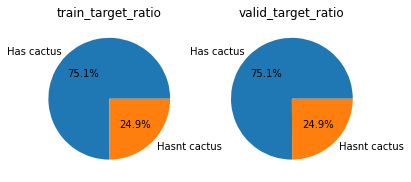

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 10))
fig, axes = plt.subplots(1, 2)


axes[0].pie(train['has_cactus'].value_counts(), labels=['Has cactus', 'Hasnt cactus'], autopct='%0.1f%%');
axes[0].set_title('train_target_ratio')
axes[1].pie(valid['has_cactus'].value_counts(), labels=['Has cactus', 'Hasnt cactus'], autopct='%0.1f%%');
axes[1].set_title('valid_target_ratio')


 - train, valid의 각각 target 비율 동일

#### 데이터셋 클래스 정의
 - 파이토치로 신경망 모델 구축하려면 데이터셋도 일정한 형식에 맞게 정의

In [79]:
import cv2
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

 - Dataset은 추상 클래스 : 객체를 곧바로 생성할 수 없고, 상속만 할 수 있는 클래스
 - 추상 클래스 사용 이유

  > 상속받는 클래스들의 메서드를 규격하 하기 위함
  
  > 상속을 강제해 메서드 시그니처 일치시킴

 - Dataset을 상속받은 다음 특수 메서드인 \_\_len__()과 \_\_getitem__()을 재정의(오버라이딩)

  > \_\_len__() : 데이터셋 크기를 반환

  > \_\_getitem__() : 인덱스를 전달받아 인덱스에 해당하는 데이터 반환

In [80]:
class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__()  # 상속받은 Dataset의 생성자 호출, # 파라미터가 비워저 있는것으로 보아 Dataset 클래스 생성자에서 파라미터 아무것도 안가져옴
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    # 데이터셋 크기 반환 메서드
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]       # 이미지 ID
        img_path = self.img_dir + img_id    # 이미지 파일 경로
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx, 1]        # 이미지 레이블(타깃값)
    
        if self.transform is not None:
            image = self.transform(image)
        return image, label

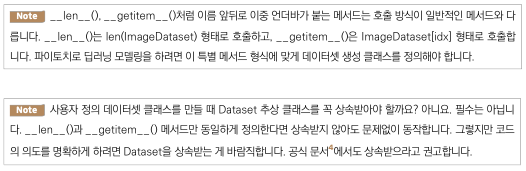

 -  클래스 상속 예재

In [81]:
class Person:
    def __init__(self, name, age):
        self.name = name
        self.age = age

    def get_name(self):
        print(f'제 이름은 {self.name}입니다.')
    
    def get_age(self):
        print(f'제 나이는 {self.age}세 입니다.')

In [82]:
class Student(Person):
    def __init__(self, name, age, GPA):
        super().__init__(name, age)
        self.GPA = GPA

    def get_GPA(self):
        print(f'제 학점은 {self.GPA}입니다.')

In [83]:
student_a = Student('김OO', 27, 3.4)
student_a.get_name()

제 이름은 김OO입니다.


 - 파이토치 모델로 이미지를 다루려면, 이미지 데이터 → 텐서 타입

In [84]:
from torchvision import transforms # 이미지 변환을 위한 모듈

transform = transforms.ToTensor()

 - torchvision : 파이토치용 컴퓨터 비전 라이브러리
 - transforms : 다양한 이미지 변환기 제공하는 모듈
 - ToTensor() 메서드 : 이미지 → 텐서

  > (채널 수, 가로 픽셀 수, 세로 픽셀 수)

  > (배치 크기, 채널 수, 가로 픽셀 수, 세로 픽셀 수)

 - 훈련 데이터셋과 검증 데이터셋 생성 : ImageDataset() 이용

In [85]:
dataset_train = ImageDataset(df=train, img_dir='train/', transform=transform)
dataset_valid = ImageDataset(df=valid, img_dir='train/', transform=transform)

#### 데이터 로더 생성
 - 데이터 로더 : 지정한 배치 크기만큼씩 데이터를 불러오는 객체
 - 배치(묶음) 단위로 데이터를 자겨와 훈련 하면 빠르다

In [86]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

 - 배치 크기가 작으면

  > 규제효과 → 일반화 성능 향상

  > 이터레이션 많아짐 → 훈련 시간 길어짐

  > 배치 크기가 작을수록 학습률도 작게 설정 → 훈련 시간 길어짐

### 합성공 신경망 모델 생성


In [87]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수를 모아둔 모듈

In [88]:
class Model(nn.Module):     # nn.Module : 모든 신경망 모듈의 기반 클래스
    # 신경망 계층 정의
    def __init__(self):
        super().__init__()  # 상속받은 nn.Module의 __init__()메서드 호출

        # 첫 번째 합성곱 계층
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,
                               kernel_size=3, padding=2)
        # 두 번째 합성곱 계층
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=3, padding=2)
        # 최대 풀링 계층
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        # 평균 풀링 계층
        self.avg_pool = nn.AvgPool2d(kernel_size=2)
        # 전결합 계층
        self.fc = nn.Linear(in_features=64 * 4 * 4, out_features=2) # 최종 출력값 개수 : 0,1 이므로 개수는 2
    # 순전파 출력 정의
    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x))) # 첫 번째 합성곱 연산 → ReLU → 최대 풀링
        x = self.max_pool(F.relu(self.conv2(x))) # 두 번째 합성곱 연산 → ReLU → 최대 풀링
        x = self.avg_pool(x) # 평균 풀링
        x = x.view(-1, 64 * 4 * 4) # 평탄화 : 판다스의 reshape() 함수와 비슷
        x = self.fc(x)
        return x

 - 이렇게 정의한 Model 클래스로 CNN모델을 생성하여 device 장비에 할당

In [89]:
model = Model().to(device) # nn.Module이 갖고 있는 to() 메서드

 - GPU에 할당한 모델을 model 변수에 저장

In [90]:
model

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

 - Tip : Model 클래스를 정의하는 또 다른 방법

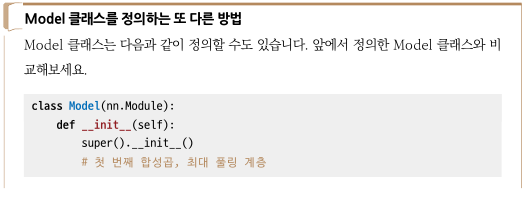

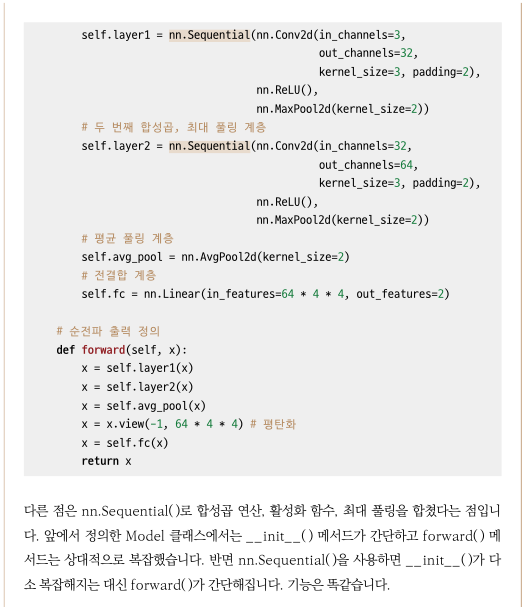

### 모델 훈련
 - 훈련에 앞서, 손실 함수와 옵티마이저 정의

#### 손실 함수 설정
 - 신경망 모델 훈련은 가중치를 갱신하는 작업
 - 가중치 갱신 : 예측값과 실제값의 손실이 작아지는 방향
 - 이때 손실값을 구하는 함수가 손실함수

In [91]:
# 손실 함수
criterion = nn.CrossEntropyLoss() # 교차 엔트로피 손실함수

#### 옵티마이저 설정
 - 최적 가중치를 찾아주는 알고리즘
 - 기본 옵티마이저 : SGD(확률적 경사 하강법 이용)

In [92]:
# 옵티마이저
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # 모델이 가진 파라미터들을 전달, lr은 학습률

#### 모델 훈련(이미지용 딥러닝 모델)

 - 1.데이터 로더에서 배치 크기만큼 데이터 불러옴
 - 2.불러온 이미지 데이터와 타깃값 데이터를 device에 할당
 - 3.옵티마이저 내 기울기 초기화
 - 4.신경망 모델에 입력 데이터(이미지) 전달, 순전파하여 출력값(예측값) 구함
 - 5.예측값과 실제 타깃값을 비교해 손실 계산
 - 6.손실을 기반으로 역전파 수행
 - 7.역전파로 구한 기울기 활용해 가중치 갱신
 - 8.[1~7] 절차를 반복 횟수만큼 되풀이
 - 9.[1~8] 절차를 에폭만큼 되풀이


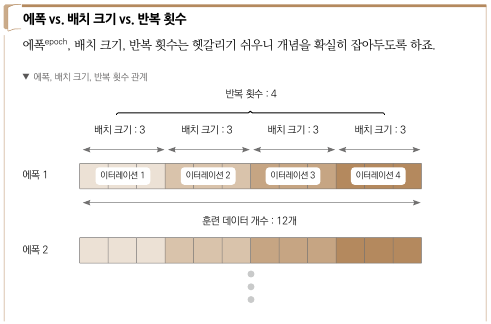

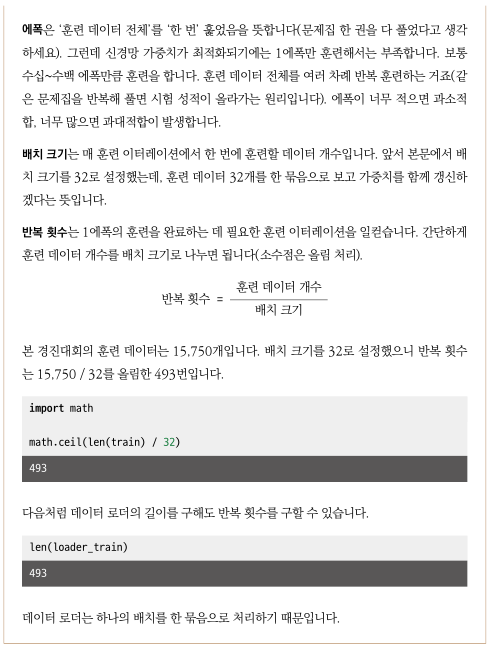

In [93]:
epochs = 10 # 총 에폭
# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0  # 에폭별 손실값 초기화

    # '반복 횟수(Iterations)'만큼 반복
    for images, labels in loader_train: # 데이터 로더는 하나의 배치를 한 묶음으로 처리
    # 이미지, 레이블 데이터 미니배치를 장비에 할당
        images = images.to(device)
        labels = labels.to(device)

        # 옵티마이저 내 기울기 초기화(매 배치 마다)
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs(예측값)와 labels(실제값)의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치(해당 Iteration)에서 손실 추가
        epoch_loss += loss.item()
        loss.backward() # 역전파 수행 : 기울기(.grad 속성)을 계산 후 저장
        # 가중치 갱신
        optimizer.step() # 새로운 가중치 = 기존 가중치 - (학습률 X 기울기)

    # 훈련 데이터 손실값 출력() : 하나의 에폭이 끝날때 마다
    print(f'에폭[{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')

에폭[1/10] - 손실값: 0.5233
에폭[2/10] - 손실값: 0.3453
에폭[3/10] - 손실값: 0.2370
에폭[4/10] - 손실값: 0.1984
에폭[5/10] - 손실값: 0.1754
에폭[6/10] - 손실값: 0.1666
에폭[7/10] - 손실값: 0.1545
에폭[8/10] - 손실값: 0.1439
에폭[9/10] - 손실값: 0.1333
에폭[10/10] - 손실값: 0.1299


 - backward() 메소드

  > Require_grad=True로 설정된 모든 텐서들에 대해 gradient를 계산

  > backpropagation에서 gradient를 계산하는 첫 starting point가 되는 값이 loss 값

  > 이 loss값을 모든 가중치들(parameters; weight and bias)에 대해서 미분을 계산

  > gradient 계산이 시작되는 지점인 loss 변수에 적용 : loss.backward()

  > backward() 메소드는 gradient를 구하려고 하는 변수들 (requires_grad = True로 인자를 전달한 변수들)에 대해 DCG에 차곡 차곡 neural net의 계산 흐름을 쌓게 된다.

  > 여기서, x_train, y_train은 DCG에 포함 되지 않는다는 것을 명심하자. 우리는 requires_grad=False로 설정한다.

  [링크 텍스트](https://velog.io/@jkl133/pytorch%EC%9D%98-autograd%EC%97%90-%EB%8C%80%ED%95%B4-%EC%95%8C%EC%95%84%EB%B3%B4%EC%9E%90)

 - .grad 어트리뷰트

  > 가중치(w, b).grad : gradient 실제값 확인

  > gradient들은 축적 됨(+= 연산)

  > 문제점 : 현재의 loss값에 해당하는 gradient를 사용해서 parameter들을 업데이트 해야하는데, gradient들이 축적되어 버리면(default로 구현되있음)?
   - 컴퓨터 메모리 자원을 고려한 알고리즘

 - zero_() 메소드

  >gradient는 축적되기 때문에, gradient를 통해 가중치를 업데이트한 후 다음으로 넘어가기 전에 zero_() 메소드를 통해 0으로 만들어 줘야함 : w.grad.zero_()
   - pytorch에서 메소드 이름뒤에 _가 들어가면 in_place 의미 : 메소드를 적용한 결과값으로 곧바로 해당 변수를 바꾼다

 - no_grad() 메소드

  > 모델이 validation하는 동안 gradient를 계산하지 않도록 함
  

### 성능 검증
 - 검증 데이터를 이용해 평가지표인 ROC AUC 값 확인

In [96]:
from sklearn.metrics import roc_auc_score

# 실제'값'과 예측'확률'을 담을 리스트 초기화
true_list = []
preds_list = []

In [97]:
model.eval() # (훈련된)모델을 평가 상태로 설정

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid: # 전체데이터에서 10%가 검증데이터

    # 이미지, 레이블 데이터 미니배치를 장비에 할당
        images = images.to(device)
        labels = labels.to(device)

        # 순전파 : 이미지 데이터(검증)를 신경망 모델(훈련된)의 입력값으로 사용해 출력값 계산(예측값)
        outputs = model(images)  # shape -> (32, 2) : 배치크기:32, 타깃값:2
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 타깃값이 1일 확률
        true = labels.cpu()
        # torch.softmax() : 타깃값 0, 1 각각의 순전파 출력값을 각각의 확률로 변환
        # ouputs.cpu() : roc_auc_score()는 파이토치가 아닌 사이킷런 함수(GPU사용 불가), ouputs,labels 데이터를 CPU로 이동
        # dim=1 : 열들(dim=1)의 합이 1이 되도록
        # [:, 1] : 타깃값 1일 확률, 즉 이미지가 선인장을 포함할 확률에 해당하는 열

        # 예측 확률과 실제 값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)

# 검증 데이터 ROC AUC 점수 계산
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}')

1750
1750
검증 데이터 ROC AUC : 0.9902


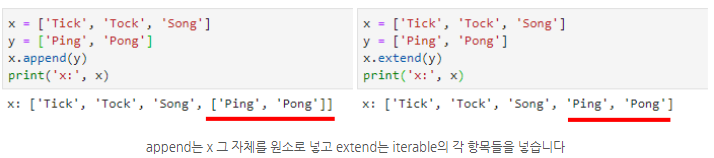

##### numpy와 torch로 구현해보는 backward()/no_grad()

In [ ]:
import numpy as np

# f = w * x

# f = 2 * x
X = np.array([1, 2, 3, 4], dtype=np.float32)
Y = np.array([2, 4, 6, 8], dtype=np.float32)

w = 0.0 # 시작은 0으로

# model prediction
def forward(x):
    return w * x

# loss = MSE
def loss(y, y_predicted):
    return ((y_predicted-y)**2).mean()

# gradient
# MSE = 1/N * (w*x - y)**2
# dJ/dw = 1/N 2x (w*x - y)
def gradient(x, y, y_predicted):
    return np.dot(2*x, y_predicted-y).mean()

print(f'Prediction before traning: f(5) = {forward(5):.3f}')

# Training
learning_rate = 0.01
n_iters = 10

for epoch in range(n_iters):
    # prediction = fowrard pass
    y_pred = forward(X)

    # loss
    l = loss(Y, y_pred)

    # gradient
    dw = gradient(X, Y, y_pred)

    # update weights
    w -= learning_rate * dw

    if epoch % 1 == 0: # 모든 epoch에 대해
        print(f'epoch {epoch+1}: w ={w:.3f}, loss = {l:.8f}')

print(f'Prediction after traning: f(5) = {forward(5):.3f}')


In [ ]:
# numpy x pytorch o

import torch

# f = w * x

# f = 2 * x
X = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
Y = torch.tensor([2, 4, 6, 8], dtype=torch.float32)

w = torch.tensor(0.0, dtype=torch.float32, requires_grad=True) # 시작은 0으로

# model prediction
def forward(x):
    return w * x

# loss = MSE
def loss(y, y_predicted):
    return ((y_predicted-y)**2).mean()

# # gradient
# # MSE = 1/N * (w*x - y)**2
# # dJ/dw = 1/N 2x (w*x - y)
# def gradient(x, y, y_predicted):
#     return np.dot(2*x, y_predicted-y).mean()

print(f'Prediction before traning: f(5) = {forward(5):.3f}')

# Training
learning_rate = 0.01
n_iters = 20

for epoch in range(n_iters):
    # prediction = fowrard pass
    y_pred = forward(X)

    # loss
    l = loss(Y, y_pred)

    # gradients = backward pass
    l.backward() # dl/dw
    
    # update weights
    with torch.no_grad():
        # with 구문 안에서 새로 생성된 텐서(파라미터 w)들은 requires_grad=False 상태가 되어, 메모리 사용량을 아껴준다.
        # 파라미터 w의 gradient를 계산하지 않겠다
        w -= learning_rate * w.grad # lr * dl/dw
        # 위에서 새로 정의된 w의 grad가 아닌, 우항의 w.grad(전역변수 w의 grad)만 유효하다

    # zero gradients
    w.grad.zero_()  # w 갱신 후 dl/dw를 초기화(0) 해주자

    if epoch % 1 == 0: # 모든 epoch에 대해
        print(f'epoch {epoch+1}: w ={w:.3f}, loss = {l:.8f}')

print(f'Prediction after traning: f(5) = {forward(5):.3f}')


### 예측 및 결과 제출
 - 테스트 데이터를 담은 데이터셋과 데이터로더 준비

In [98]:
dataset_test = ImageDataset(df=submission, img_dir='test/', transform=transform)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

#### 예측
 - 테스트 데이터에서 타깃값이 1일 확률 예측

In [99]:
model.eval() # 모델을 평가/예측 상태로 설정

preds = []  # 타깃 예측값 저장용 리스트 초기화

with torch.no_grad():   # 기울기 계산 비활성화
    for images, _ in loader_test:   # 테스트 데이터에는 타깃값이 없어서 할당X
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타깃값이 1일 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1] # kaggle 제출용은 tensor타입 불가
        preds.extend(preds_part)


In [100]:
submission['has_cactus'] = preds
submission['has_cactus']

0       tensor(0.9813)
1       tensor(0.9999)
2       tensor(0.0906)
3       tensor(0.1021)
4       tensor(0.8743)
             ...      
3995    tensor(0.9961)
3996    tensor(1.0000)
3997    tensor(0.9994)
3998    tensor(0.9924)
3999    tensor(0.8974)
Name: has_cactus, Length: 4000, dtype: object

 - tensor타입 제출 불가 : tolist()

In [ ]:
model.eval() # 모델을 평가/예측 상태로 설정

preds = []  # 타깃 예측값 저장용 리스트 초기화

with torch.no_grad():   # 기울기 계산 비활성화
    for images, _ in loader_test:   # 테스트 데이터에는 타깃값이 없어서 할당X
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타깃값이 1일 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist() # kaggle 제출용은 tensor타입 불가
        preds.extend(preds_part)


In [101]:
submission['has_cactus'] = preds
submission.to_csv('submission.csv', index=False)